In [1]:
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from neo4j_runway import Discovery
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.utils.data import load_data_dictionary_from_yaml, load_local_files

from dotenv import load_dotenv

load_dotenv()

True

# Load Data

In [3]:
use_cases = ["How many subregions are in a region and how many countries are in a subregion?",
    "What is the most common currency?",
    "Which subregions contain the most cities?"]
data_dictionary = load_data_dictionary_from_yaml("./data_dictionary.yaml")
data = load_local_files(data_directory="../../../data/countries/", general_description="These files contain information on countries.", use_cases=use_cases, data_dictionary=data_dictionary)

# Discovery

In [4]:
disc_llm = OpenAIDiscoveryLLM(model_name="gpt-4o-mini-2024-07-18", enable_async=True)
discovery = Discovery(llm=disc_llm, data=data)

/Users/alexandergilmore/Documents/projects/neo4j-runway/neo4j_runway/discovery/discovery.py:137: ExperimentalFeatureWarning: Multi file Discovery is an experimental feature and may not work as expected. Please use with caution and raise any issues encountered here: https://github.com/a-s-g93/neo4j-runway/issues
  warnings.warn(


In [5]:
discovery.run_async(num_calls=3)

### Summary of Insights for Graph Data Model

#### Unique Identifiers
- **City ID**: Unique identifier for each city from the `cities.csv` dataset.
- **Country ID**: Unique identifier for each country from the `countries.csv` dataset.
- **State ID**: Unique identifier for each state from the `states.csv` dataset.

#### Significant Properties
- **City Name**: Name of the city.
- **Country Name**: Name of the country.
- **Capital**: Capital city of the country.
- **Currency**: Currency used by the country.
- **Region**: Region to which the country belongs.
- **Subregion**: Subregion to which the country belongs.
- **State Name**: Name of the state.

#### Possible Node Labels
- **City**: Represents individual cities.
- **Country**: Represents individual countries.
- **State**: Represents individual states.
- **Subregion**: Represents subregions.
- **Region**: Represents regions.

#### Possible Relationships
- **(City)-[:LOCATED_IN]->(Country)**: Indicates that a city is located in a specific country.
- **(Country)-[:PART_OF]->(Subregion)**: Indicates that a country is part of a specific subregion.
- **(Subregion)-[:PART_OF]->(Region)**: Indicates that a subregion is part of a specific region.
- **(Country)-[:HAS_CURRENCY]->(Currency)**: Indicates the currency used by a country.
- **(State)-[:LOCATED_IN]->(Country)**: Indicates that a state is located in a specific country.

#### Use Case Insights
1. **Subregions and Countries**:
   - There are **22 unique subregions** in the dataset. Each subregion can contain multiple countries, which can be analyzed through the `Country` nodes linked to `Subregion` nodes.

2. **Most Common Currency**:
   - The dataset identifies the **Euro (EUR)** as the most common currency, used by **35 countries**. This can be represented through the `Currency` node linked to the `Country` nodes.

3. **Subregions with Most Cities**:
   - By linking `City` nodes to `Country` nodes and then to `Subregion` nodes, we can analyze which subregions contain the most cities, providing insights into urban distribution across subregions.

In [6]:
# with open("./outputs/final_discovery.md") as f:
#     discovery = f.read()

In [7]:
# print(discovery)

## Save Insights

In [8]:
# discovery.to_markdown(file_dir="./outputs/")

# Data Modeling

In [9]:
from neo4j_runway import GraphDataModeler

In [10]:
modeling_llm = OpenAIDataModelingLLM(model_name="gpt-4o", model_params={"temperature": 0.3})
gdm = GraphDataModeler(llm=modeling_llm, discovery=discovery, data_dictionary=data_dictionary)

/Users/alexandergilmore/Documents/projects/neo4j-runway/neo4j_runway/modeler/modeler.py:115: ExperimentalFeatureWarning: Multi file Data Modeling is an experimental feature and may not work as expected. Please use with caution and raise any issues encountered here: https://github.com/a-s-g93/neo4j-runway/issues
  warnings.warn(


In [11]:
gdm.create_initial_model(use_advanced_data_model_generation_rules=True)

> Generating Nodes...
Attempts | 1  
Received Valid Nodes
Nodes
* (:City)     * (:Country)
* (:State)    * (:Subregion)
* (:Region)    

> Generating Data Model...
Attempts | 3  
Recieved Valid Data Model
Nodes
* (:City)     * (:Country)
* (:State)    * (:Subregion)
* (:Region)   * (:Currency) 

Relationships
* (:City)-[:LOCATED_IN]->(:Country)         
* (:Country)-[:PART_OF]->(:Subregion)       
* (:Subregion)-[:PART_OF]->(:Region)        
* (:Country)-[:HAS_CURRENCY]->(:Currency)   
* (:State)-[:LOCATED_IN]->(:Country)        


DataModel(nodes=[Node(label='City', properties=[Property(name='cityId', type='str', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='cityName', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='cities.csv'), Node(label='Country', properties=[Property(name='countryId', type='str', column_mapping='id', alias='country_id', is_unique=True, part_of_key=False), Property(name='countryName', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False)], source_name='countries.csv'), Node(label='State', properties=[Property(name='stateId', type='str', column_mapping='id', alias='state_id', is_unique=True, part_of_key=False), Property(name='stateName', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='states.csv'), Node(label='Subregio

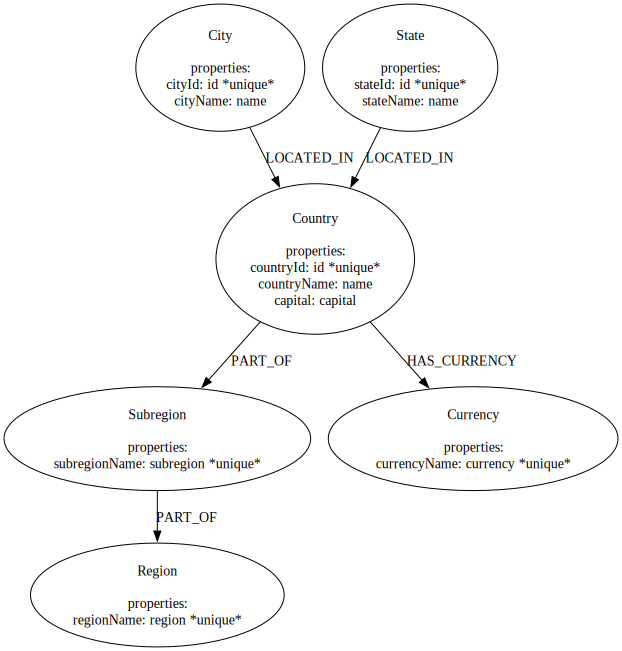

In [12]:
gdm.current_model.visualize()

In [13]:
corrections = "Create a relationship between City and State"

gdm.iterate_model(corrections=corrections)

> Generating Data Model...
Attempts | 2  
Recieved Valid Data Model
Nodes
* (:City)     * (:Country)
* (:State)    * (:Subregion)
* (:Region)   * (:Currency) 

Relationships
* (:City)-[:LOCATED_IN]->(:Country)         
* (:Country)-[:PART_OF]->(:Subregion)       
* (:Subregion)-[:PART_OF]->(:Region)        
* (:Country)-[:HAS_CURRENCY]->(:Currency)   
* (:State)-[:LOCATED_IN]->(:Country)        
* (:City)-[:LOCATED_IN]->(:State)           


DataModel(nodes=[Node(label='City', properties=[Property(name='cityId', type='str', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='cityName', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='cities.csv'), Node(label='Country', properties=[Property(name='countryId', type='str', column_mapping='id', alias='country_id', is_unique=True, part_of_key=False), Property(name='countryName', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False)], source_name='countries.csv'), Node(label='State', properties=[Property(name='stateId', type='str', column_mapping='id', alias='state_id', is_unique=True, part_of_key=False), Property(name='stateName', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='states.csv'), Node(label='Subregio

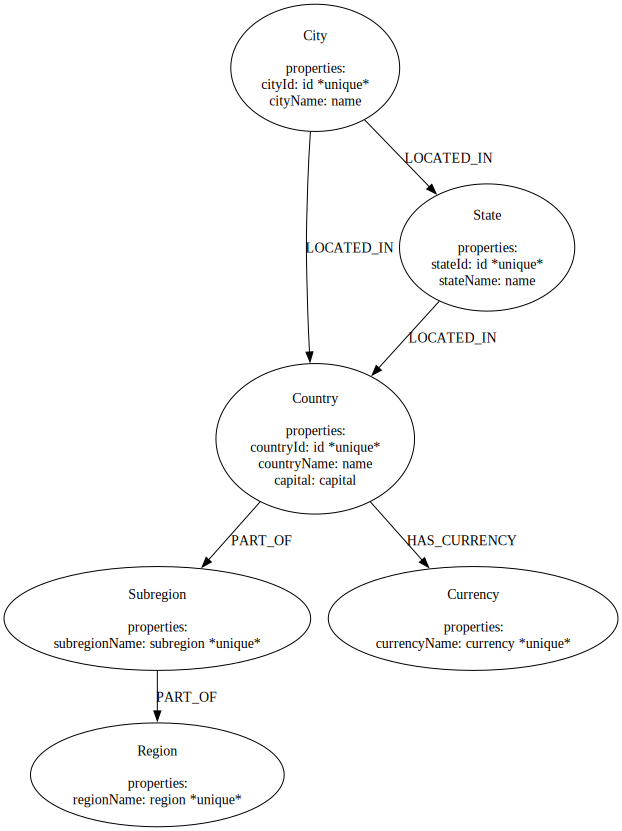

In [14]:
gdm.current_model.visualize()